In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import gpplot as gpp
gpp.set_aesthetics(context='paper')

In [2]:
def load_hyperparams(filename):
    hyperparams = {}
    with open(filename, 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            try:
                value = float(value) if '.' in value else int(value)
            except ValueError:
                pass  
            hyperparams[key] = value
    return hyperparams

In [3]:
best_hyperparams = load_hyperparams('../../Data/modelTraining/')
best_hyperparams

{'lambda': 0.00461089989462071,
 'alpha': 2.339185431719978,
 'subsample': 0.8843557017194346,
 'colsample_bytree': 0.7795190399711517,
 'max_depth': 5,
 'learning_rate': 0.008204611244539674,
 'n_estimators': 766}

In [4]:
modelTrainingPath = "../Data/modelTraining/"
train_df = pd.read_csv(f'{modelTrainingPath}trainData.csv')
X = train_df.drop(columns=['doubleZscore', 'Target_Gene_Symbol']).copy()
y = train_df['doubleZscore']
# train the final model on the test dataset
final_model = xgb.XGBRegressor(**best_hyperparams)
final_model.fit(X, y)

# save this model (it uses one hot coding)
final_model.save_model('model_v2.json')

In [5]:
test_df = pd.read_csv(f'{modelTrainingPath}testData.csv')
Xtest = test_df.drop(columns=['doubleZscore', 'Target_Gene_Symbol']).copy()
ytest = test_df['doubleZscore']

predictions_test = final_model.predict(Xtest)
rmse_test = mean_squared_error(ytest, predictions_test, squared=False)
print(f"RMSE on the training data: {rmse_test:.4f}")

RMSE on the training data: 0.8541


In [6]:
test_df['yPred'] = final_model.predict(Xtest)

In [7]:
test_df

,Target_Gene_Symbol,ATAC_overlap_with_peak_sum,DHS_overlap_with_peak_sum,H3K4me3,H3k27ac,sgRNA_'Cut'_Site_TSS_Offset,doubleZscore,rs3ChenSeqScore,Domain_Kox1,Domain_Zim3,...,TSS_Bucket__-5kb_to_5kb___775__800_,TSS_Bucket__-5kb_to_5kb___800__825_,TSS_Bucket__-5kb_to_5kb___825__850_,TSS_Bucket__-5kb_to_5kb___850__875_,TSS_Bucket__-5kb_to_5kb___875__900_,TSS_Bucket__-5kb_to_5kb___900__925_,TSS_Bucket__-5kb_to_5kb___925__950_,TSS_Bucket__-5kb_to_5kb___950__975_,TSS_Bucket__-5kb_to_5kb___975__1000_,yPred
0,ATIC,2,0,3,3,-412.0,0.005957,-0.339995,1,0,...,0,0,0,0,0,0,0,0,0,-0.484888
1,ATIC,2,0,3,3,-412.0,-0.017525,-0.339995,0,1,...,0,0,0,0,0,0,0,0,0,-0.534311
2,ATIC,1,0,2,3,-923.0,-0.239950,0.106215,1,0,...,0,0,0,0,0,0,0,0,0,-0.524100
3,ATIC,1,0,2,3,-923.0,-0.186008,0.106215,0,1,...,0,0,0,0,0,0,0,0,0,-0.613666
4,ATIC,3,0,3,3,-369.0,0.559061,0.799858,1,0,...,0,0,0,0,0,0,0,0,0,-0.379419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32829,ZNHIT6,7,0,3,3,-293.0,-0.458460,0.590918,1,0,...,0,0,0,0,0,0,0,0,0,-0.157224
32830,ZNHIT6,7,3,3,3,-80.0,-0.478862,-0.455622,1,0,...,0,0,0,0,0,0,0,0,0,-0.237433
32831,ZNHIT6,6,0,3,3,541.0,-0.386223,0.449871,1,0,...,0,0,0,0,0,0,0,0,0,0.200807
32832,ZNHIT6,1,0,3,2,943.0,-0.296669,-0.544459,1,0,...,0,0,0,0,0,0,1,0,0,-0.464490


In [8]:
def calculate_spearman_within_groups(df):
    spearman_corrs = []
    groups = df['Target_Gene_Symbol'].unique()
    
    for group in groups:
        group_data = df[df['Target_Gene_Symbol'] == group]
        yPred_corr, _ = spearmanr(group_data['doubleZscore'], group_data['yPred'])
        RS3_corr, _ = spearmanr(group_data['doubleZscore'], group_data['rs3ChenSeqScore'])
        spearman_corrs.append({'Target_Gene_Symbol': group, 'spearman_corr_yPred': yPred_corr, 'spearman_corr_RS3': RS3_corr})
    
    return pd.DataFrame(spearman_corrs)

spearman_df = calculate_spearman_within_groups(test_df)



{'whiskers': [<matplotlib.lines.Line2D at 0x17ee24580>,
 'caps': [<matplotlib.lines.Line2D at 0x17ee24ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x17ee242e0>,
 'medians': [<matplotlib.lines.Line2D at 0x17ee33040>,
 'fliers': [<matplotlib.lines.Line2D at 0x17ee332e0>,
 'means': []}

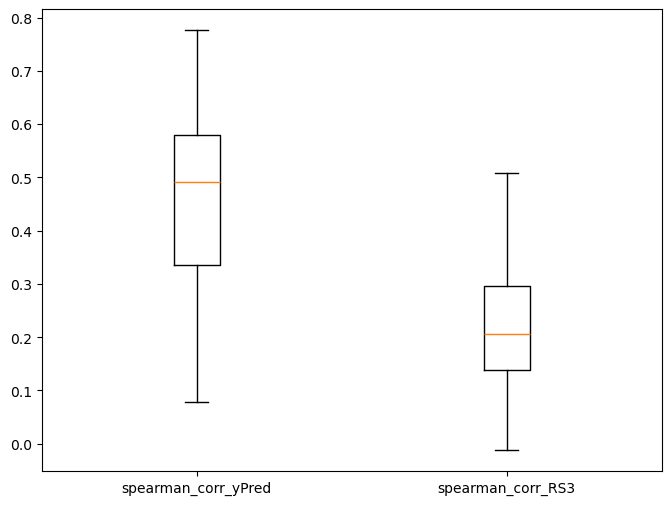

In [9]:
# Plot the boxplot of Spearman correlations
plt.figure(figsize=(8, 6))
plt.boxplot(spearman_df[['spearman_corr_yPred', 'spearman_corr_RS3']], 
            labels=['spearman_corr_yPred', 'spearman_corr_RS3'])
# test is 67% (44% guide) gene in nunez, 30% gene (55% guide)in inhouse, 3% gene (5% guide) in gilbert

In [10]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(spearman_df['spearman_corr_yPred'], 
                             spearman_df['spearman_corr_RS3'], alternative='greater')
p_value


1.547423812714253e-18

In [11]:
spearman_df_underperforming = spearman_df[spearman_df.spearman_corr_yPred < spearman_df['spearman_corr_yPred'].quantile(0.25)]

In [12]:
spearman_df[spearman_df['spearman_corr_yPred'] < spearman_df['spearman_corr_RS3']]

,Target_Gene_Symbol,spearman_corr_yPred,spearman_corr_RS3
7,CARF,0.208436,0.376592
77,SIRT7,0.130350,0.141507
92,ZNF131,0.124209,0.154794


In [13]:
import shap

In [14]:
explainer = shap.TreeExplainer(final_model)

In [15]:
shap_values = explainer(Xtest)


In [16]:
shap_df = pd.DataFrame(shap_values.values, columns=Xtest.columns)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)
top_features = mean_shap_values.head(10)

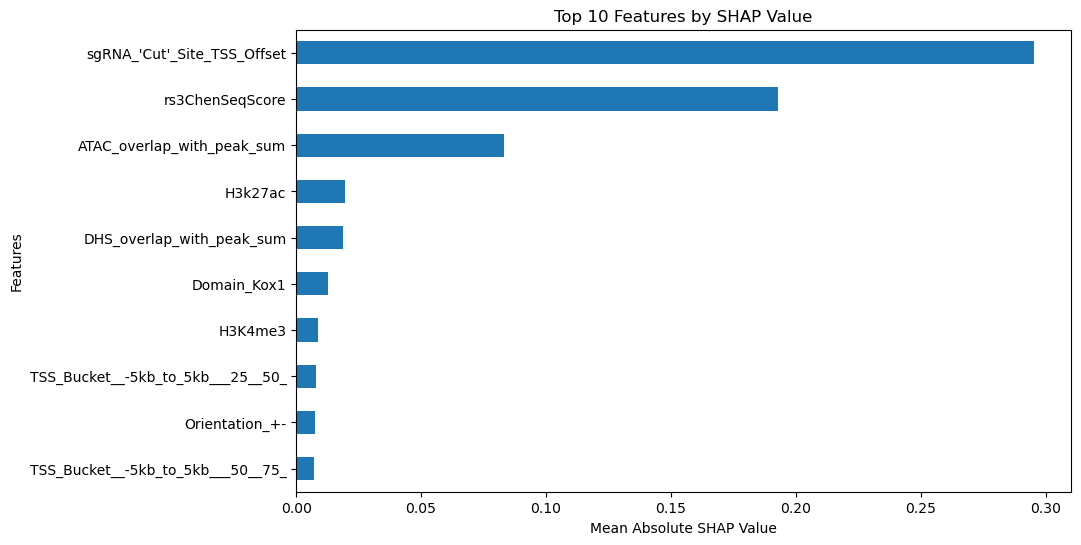

In [17]:
plt.figure(figsize=(10, 6))
top_features.sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Features by SHAP Value')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.show()

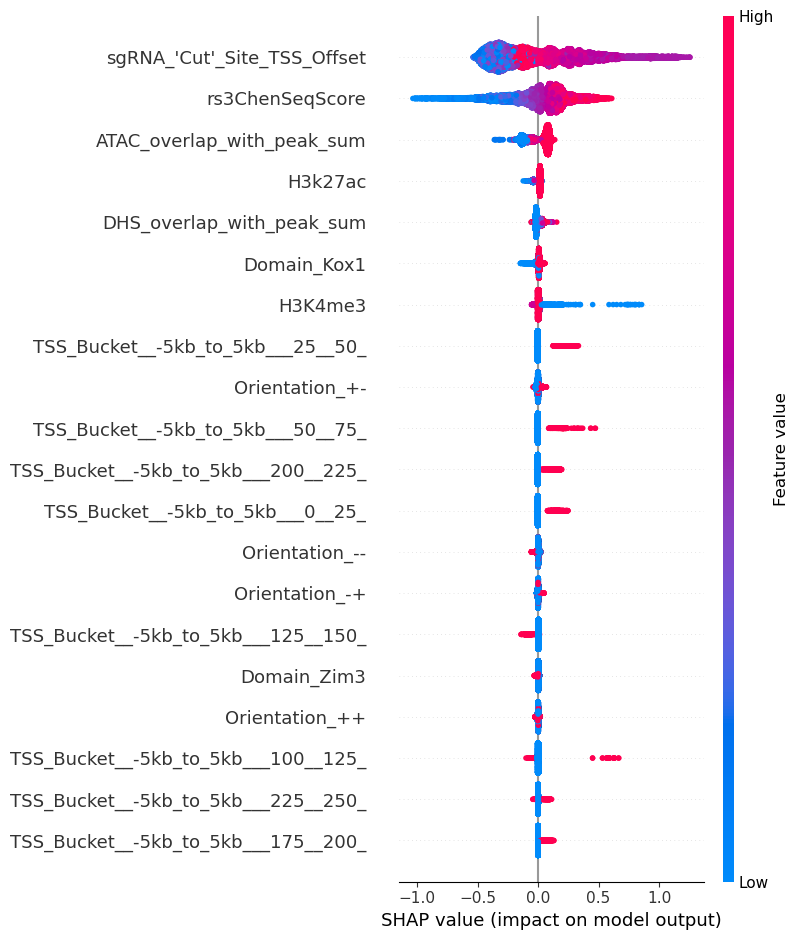

In [18]:
shap.summary_plot(shap_values, Xtest)

In [23]:
Xtest_renamed = Xtest.copy()
Xtest_renamed.columns = ['ATAC overlap with peak proportion', 'DHS overlap with peak proportion',
                         'H3K4me3 overlap with peak proportion', 'H3k27ac overlap with peak proportion',
                         'sgRNA \'Cut\' Site TSS Offset', 'RS3 Sequence Score (with Chen tracrRNA)',
                         'Kox1 Domain', 'Zim3 Domain', '++ Orientation', '+- Orientation'] + Xtest.columns[10:].tolist()
Xtest_renamed
shap_values = explainer(Xtest_renamed)
Xtest_renamed.iloc[:,:10]

,ATAC overlap with peak proportion,DHS overlap with peak proportion,H3K4me3 overlap with peak proportion,H3k27ac overlap with peak proportion,sgRNA 'Cut' Site TSS Offset,RS3 Sequence Score (with Chen tracrRNA),Kox1 Domain,Zim3 Domain,++ Orientation,+- Orientation
0,2,0,3,3,-412.0,-0.339995,1,0,1,0
1,2,0,3,3,-412.0,-0.339995,0,1,1,0
2,1,0,2,3,-923.0,0.106215,1,0,1,0
3,1,0,2,3,-923.0,0.106215,0,1,1,0
4,3,0,3,3,-369.0,0.799858,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
32829,7,0,3,3,-293.0,0.590918,1,0,0,0
32830,7,3,3,3,-80.0,-0.455622,1,0,0,0
32831,6,0,3,3,541.0,0.449871,1,0,0,0
32832,1,0,3,2,943.0,-0.544459,1,0,0,0


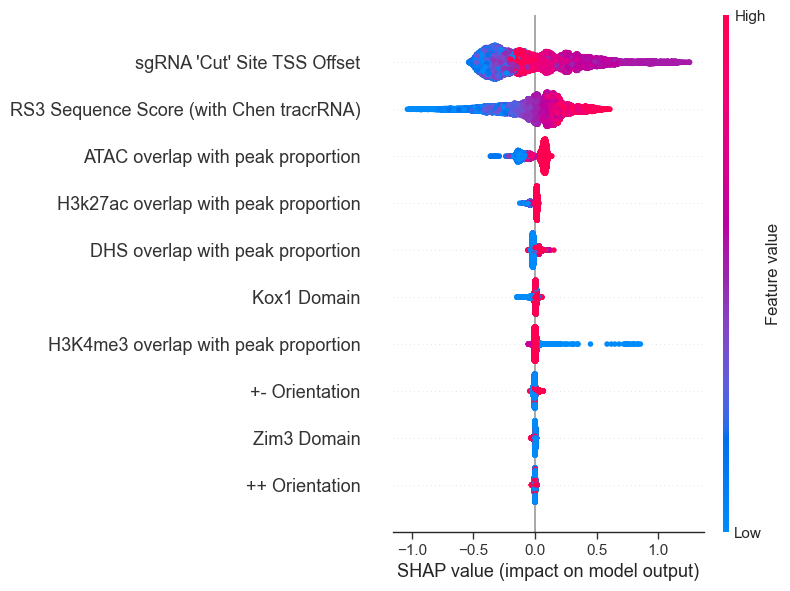

In [24]:
shap.summary_plot(shap_values[:, :10], Xtest_renamed.iloc[:,:10], plot_size=(8, 6), show=False)
gpp.savefig('../Figure/Figure 5/Individual Figures/shap_summary_top10.pdf', dpi = 300, bbox_inches='tight')


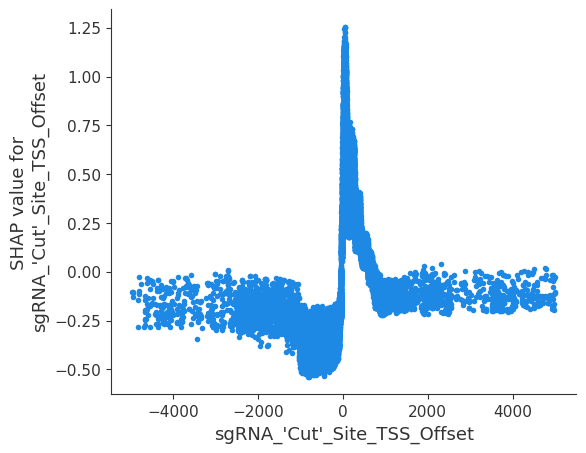

In [18]:
shap.dependence_plot("sgRNA_'Cut'_Site_TSS_Offset", shap_values.values, Xtest, interaction_index=None)


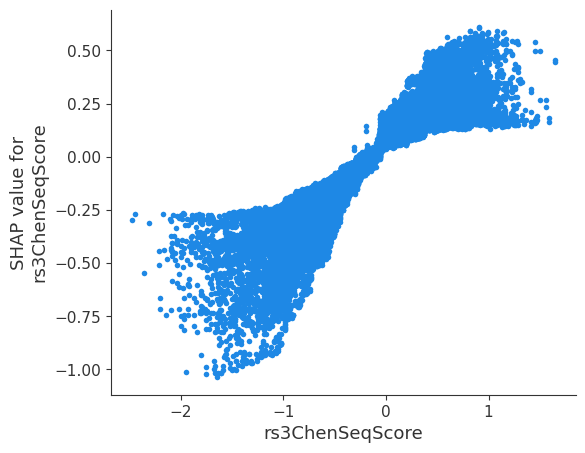

In [19]:
shap.dependence_plot("rs3ChenSeqScore", shap_values.values, Xtest, interaction_index=None)


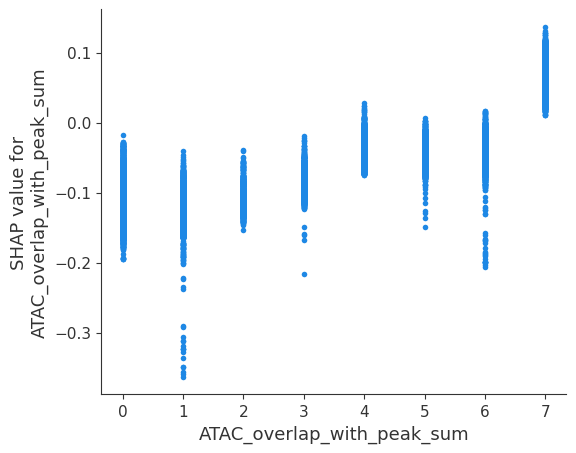

In [20]:
shap.dependence_plot("ATAC_overlap_with_peak_sum", shap_values.values, Xtest, interaction_index=None)
# boxplot 0-6 vs 7

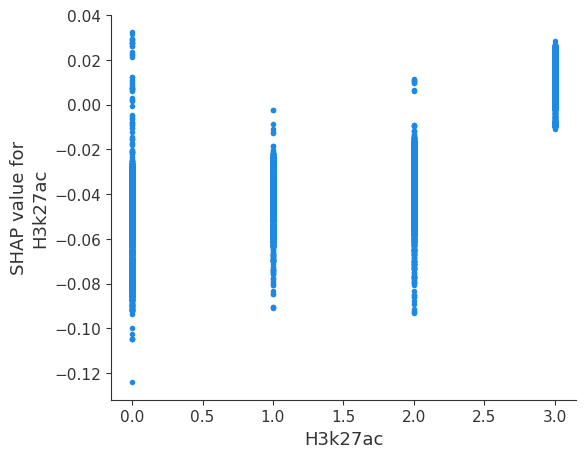

In [21]:
shap.dependence_plot("H3k27ac", shap_values.values, Xtest, interaction_index=None)


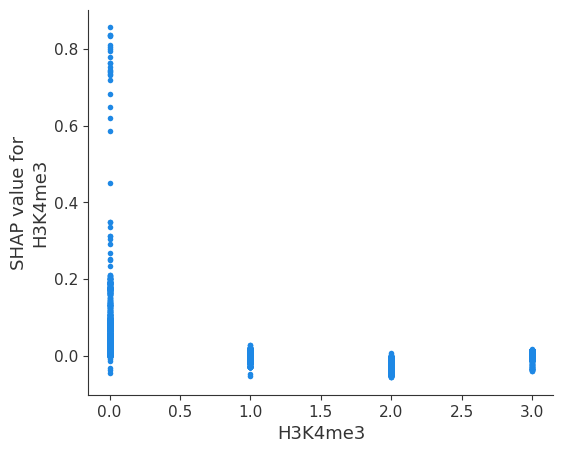

In [22]:
shap.dependence_plot("H3K4me3", shap_values.values, Xtest, interaction_index=None)


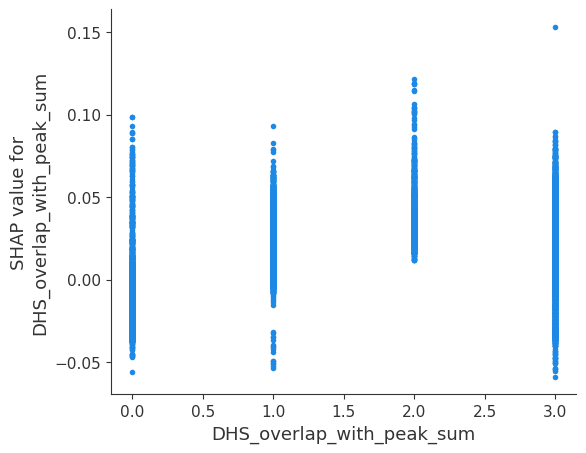

In [23]:
shap.dependence_plot("DHS_overlap_with_peak_sum", shap_values.values, Xtest, interaction_index=None)


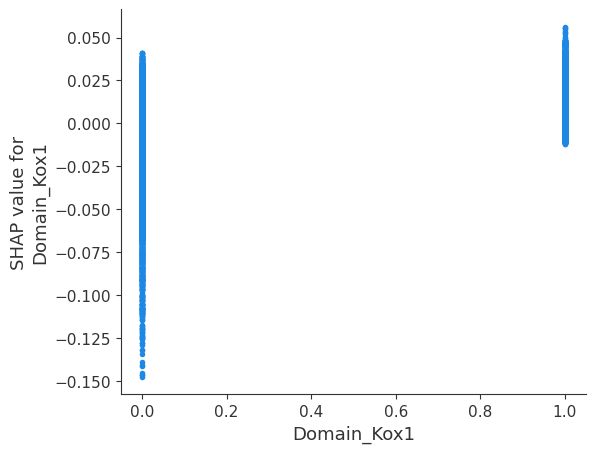

In [24]:
shap.dependence_plot("Domain_Kox1", shap_values.values, Xtest, interaction_index=None)


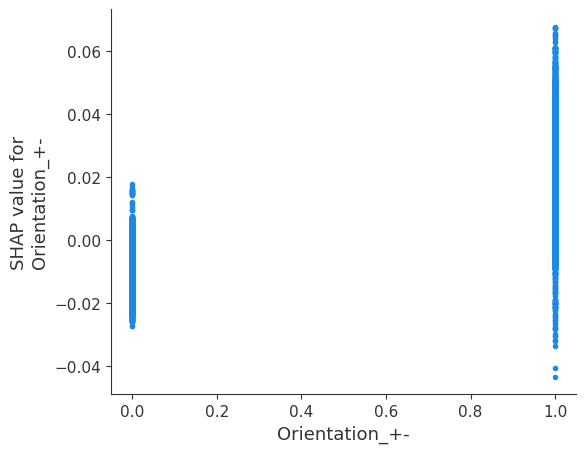

In [25]:
shap.dependence_plot("Orientation_+-", shap_values.values, Xtest, interaction_index=None)


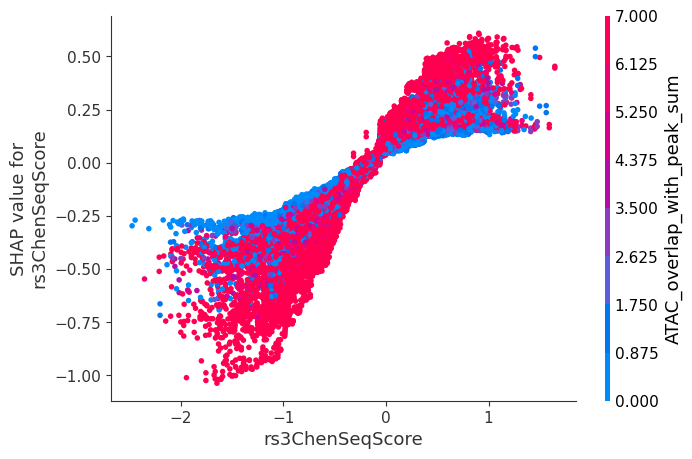

In [26]:
shap.dependence_plot("rs3ChenSeqScore", shap_values.values, Xtest, interaction_index="ATAC_overlap_with_peak_sum")


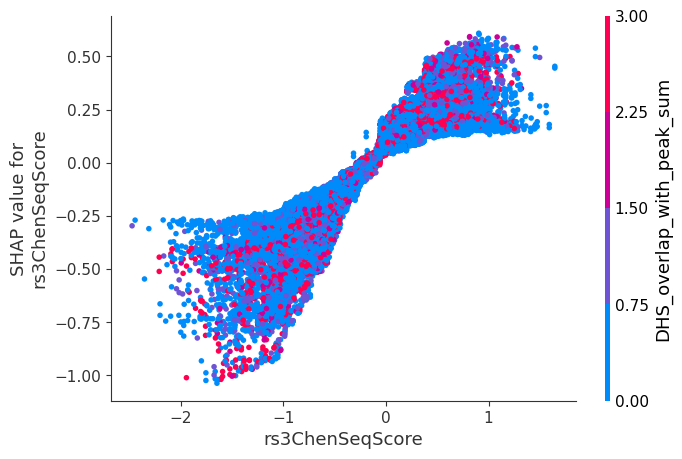

In [27]:
shap.dependence_plot("rs3ChenSeqScore", shap_values.values, Xtest, interaction_index="DHS_overlap_with_peak_sum")


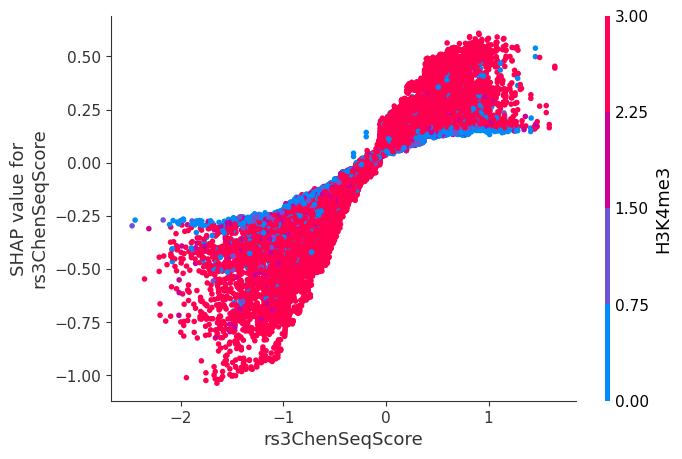

In [28]:
shap.dependence_plot("rs3ChenSeqScore", shap_values.values, Xtest, interaction_index="H3K4me3")


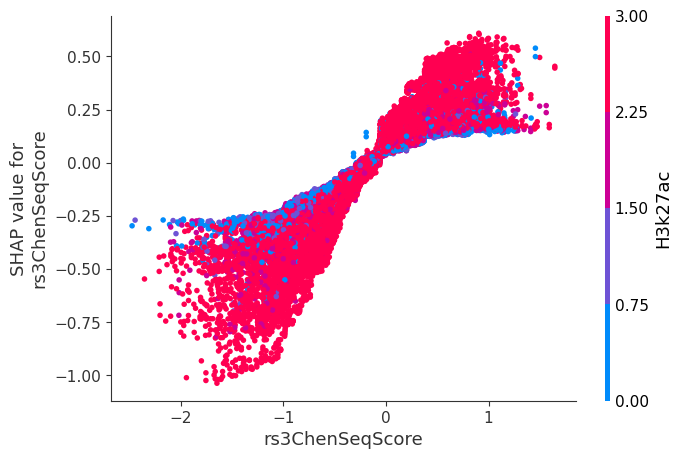

In [29]:
shap.dependence_plot("rs3ChenSeqScore", shap_values.values, Xtest, interaction_index="H3k27ac")


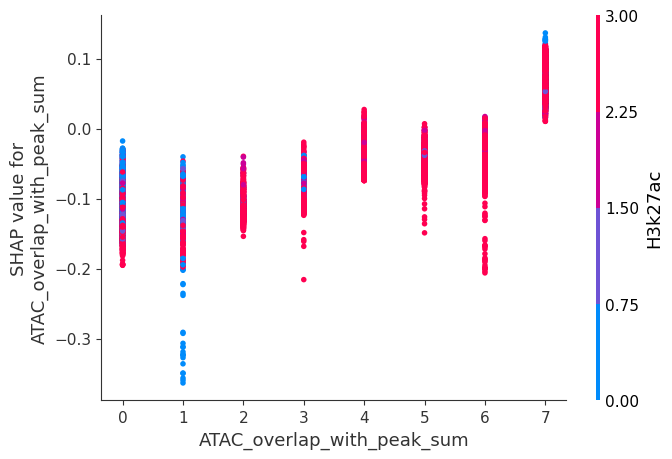

In [30]:
shap.dependence_plot("ATAC_overlap_with_peak_sum", shap_values.values, Xtest, interaction_index="H3k27ac")


In [40]:
shap_df

,ATAC_overlap_with_peak_sum,DHS_overlap_with_peak_sum,H3K4me3,H3k27ac,sgRNA_'Cut'_Site_TSS_Offset,rs3ChenSeqScore,Domain_Kox1,Domain_Zim3,Orientation_++,Orientation_+-,...,TSS_Bucket__-5kb_to_5kb___750__775_,TSS_Bucket__-5kb_to_5kb___775__800_,TSS_Bucket__-5kb_to_5kb___800__825_,TSS_Bucket__-5kb_to_5kb___825__850_,TSS_Bucket__-5kb_to_5kb___850__875_,TSS_Bucket__-5kb_to_5kb___875__900_,TSS_Bucket__-5kb_to_5kb___900__925_,TSS_Bucket__-5kb_to_5kb___925__950_,TSS_Bucket__-5kb_to_5kb___950__975_,TSS_Bucket__-5kb_to_5kb___975__1000_
0,-0.113075,-0.022065,0.001469,0.012482,-0.309911,-0.048830,0.008142,0.001655,0.002220,-0.002779,...,-1.357965e-07,-1.475760e-06,0.000020,-0.000243,-0.000003,-3.476373e-07,-0.000007,0.000023,0.000226,0.000158
1,-0.108654,-0.021819,0.002280,0.012465,-0.320986,-0.052254,-0.023657,-0.004682,0.000846,-0.002319,...,-1.357965e-07,-1.476871e-06,0.000020,-0.000245,-0.000003,-1.590586e-06,-0.000008,0.000034,0.000225,0.000158
2,-0.172960,-0.018416,-0.031686,0.014563,-0.383519,0.063870,0.010436,0.003103,0.002758,-0.003800,...,-1.357965e-07,-1.475760e-06,0.000019,-0.000174,-0.000013,-3.476373e-07,-0.000019,0.000025,0.000117,0.000107
3,-0.190774,-0.018759,-0.036978,0.014900,-0.404913,0.074661,-0.029986,-0.009336,0.001169,-0.004000,...,-1.357965e-07,-1.476871e-06,0.000019,-0.000177,-0.000013,-1.590586e-06,-0.000020,0.000035,0.000117,0.000107
4,-0.081279,-0.022607,0.011061,0.016834,-0.470698,0.168197,0.001961,0.000942,-0.001197,0.010876,...,-1.357965e-07,-1.022152e-05,0.000014,-0.000278,-0.000002,-3.476373e-07,-0.000018,-0.000008,0.000057,0.000042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32829,0.089337,-0.019888,0.004684,0.014796,-0.400509,0.176211,0.003381,0.000850,-0.002971,-0.000164,...,-1.357965e-07,4.236549e-06,0.000014,-0.000122,-0.000002,-1.906385e-07,-0.000015,0.000046,0.000057,0.000023
32830,0.069409,0.019184,0.001964,0.014812,-0.205486,-0.132179,0.009388,0.002026,-0.000594,0.000936,...,-1.357965e-07,2.140598e-07,0.000020,-0.000200,-0.000002,-1.906385e-07,-0.000004,0.000017,0.000113,0.000058
32831,-0.033218,-0.022549,-0.003986,0.014315,0.070794,0.249035,-0.005386,-0.001132,0.003471,-0.017469,...,-1.357965e-07,2.302339e-07,0.000014,-0.000238,-0.000002,-3.476373e-07,-0.000035,0.000041,0.000096,0.000037
32832,-0.111541,-0.010362,-0.002328,-0.021568,-0.135577,-0.149663,0.006404,0.001628,0.001651,-0.008122,...,-4.486679e-07,-2.892604e-06,0.000052,-0.000191,-0.000021,-3.476373e-07,-0.000006,-0.003331,0.000242,0.000126


In [46]:
### gene didnt predict well
test_df = pd.read_csv(f'{modelTrainingPath}testData.csv')
test_df_underperformingGene = test_df[test_df.Target_Gene_Symbol.isin(spearman_df_underperforming.Target_Gene_Symbol)]
Xtest_underperformingGene = test_df_underperformingGene.drop(columns=['doubleZscore', 'Target_Gene_Symbol']).copy()
ytest_underperformingGene = test_df_underperformingGene['doubleZscore']


In [47]:
shap_values_underperformingGene = explainer(Xtest_underperformingGene)


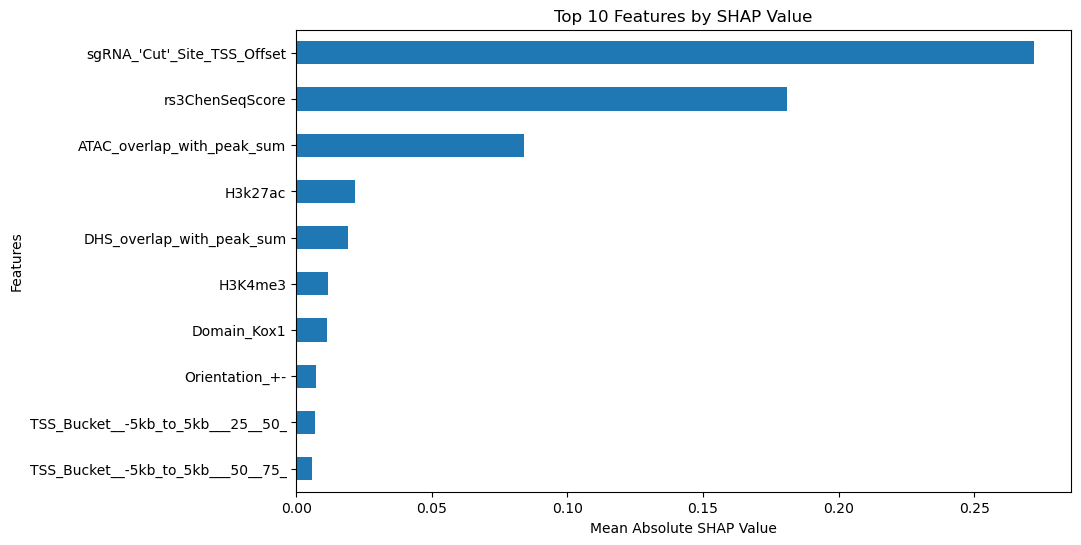

In [50]:
shap_df_underperformingGene = pd.DataFrame(shap_values_underperformingGene.values, columns=Xtest_underperformingGene.columns)
mean_shap_values_underperformingGene = shap_df_underperformingGene.abs().mean().sort_values(ascending=False)
top_features_underperformingGene = mean_shap_values_underperformingGene.head(10)

plt.figure(figsize=(10, 6))
top_features_underperformingGene.sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Features by SHAP Value')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.show()
# this and the figure below goes together 

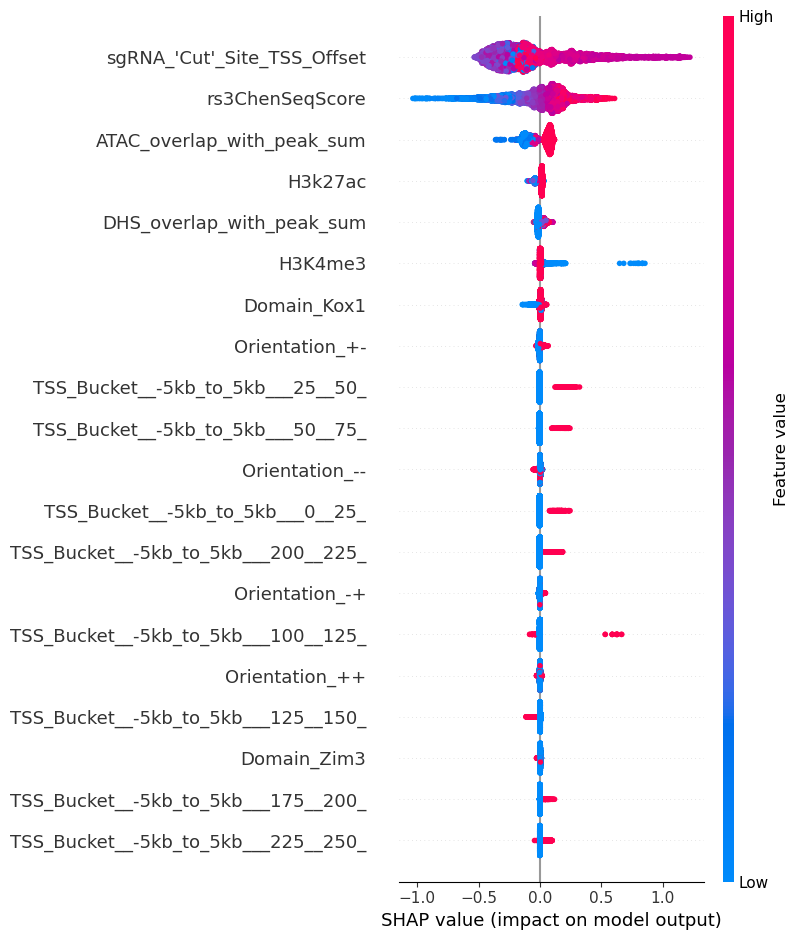

In [48]:
shap.summary_plot(shap_values_underperformingGene, Xtest_underperformingGene)

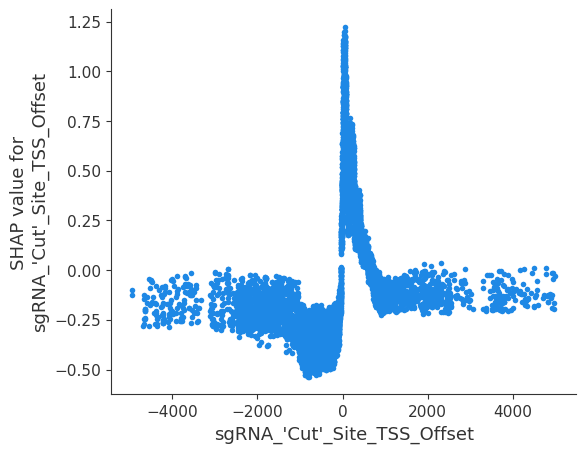

In [49]:
shap.dependence_plot("sgRNA_'Cut'_Site_TSS_Offset", shap_values_underperformingGene.values, Xtest_underperformingGene, interaction_index=None)
# zoom in on the shap value 